In [104]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from lib import rk45

In [105]:
def domain(n, d=100):
    # domain: [x, left_idx, middle_idx, right_idx]
    x = np.linspace(-d, d, 2*n+1)
    left_idx = np.arange(n)
    right_idx = np.arange(n+1, 2*n+1)
    middle_idx = n
    return [x, left_idx, middle_idx, right_idx]


def initial_gauss(x, idx, premik):
    # idx is either left_idx or right_idx
    y = np.zeros_like(x)
    d = x[-1] - x[0]
    y[idx] = np.exp(-(x[idx]-premik)**2)
    return y


def get_derivative_matrix(n, order=4):
    order_coeffs = [[-2, 1], [-5/2, 4/3, -1/12], [-49/18, 3/2, -3/20, 1/90],
                    [-205 / 72, 8 / 5, -1 / 5, 8 / 315, -1 / 560],
                    [-5269 / 1800, 5 / 3, -5 / 21, 5 / 126, -5 / 1008, 1 / 3150],
                    [-5369 / 1800, 12 / 7, -15 / 56, 10 / 189, -1 / 112, 2 / 1925, -1 / 16632]]
    coeffs = order_coeffs[order-2]
    a = np.zeros((n, n), dtype=np.float64)
    for i, c in enumerate(coeffs):
        if i != 0:
            a += np.diag(np.ones(n-i), k=i) * c
        a += np.diag(np.ones(n-i), k=-i) * c
    return csr_matrix(a)


def old_get_derivative_matrix(n, order=3):
    # n is the number of space points
    # order is the order of the 2nd derivative matrix
    assert order in [2,3]
    if order == 3:
        a = np.diag(np.ones(n), k=0) * (-5/2)
        a += np.diag(np.ones(n-1), k=1) * 4/3
        a += np.diag(np.ones(n-1), k=-1) * 4/3
        a += np.diag(np.ones(n-2), k=2) * (-1/12)
        a += np.diag(np.ones(n-2), k=-2) * (-1/12)
        return csr_matrix(a)
    data = []
    row = []
    col = []
    for i in range(n):
        data.append(-2)
        row.append(i)
        col.append(i)
        if i < n-1:
            data.append(1)
            row.append(i)
            col.append(i+1)
            data.append(1)
            row.append(i+1)
            col.append(i)
    data = np.array(data)
    row = np.array(row)
    col = np.array(col)
    A = csr_matrix((data, (row, col)), shape=(n, n))
    A[0, :] = 0
    A[-1, :] = 0
    return A


def dydt(y, domain, A, Qu=0., Qv=0.):
    x, left_idx, middle_idx, right_idx = domain
    left_middle_idx = np.concatenate((left_idx, [middle_idx]))
    middle_right_idx = np.concatenate(([middle_idx], right_idx))
    n = len(x) // 2
    d = x[-1] - x[0]
    h = abs(x[1] - x[0])
    # A = sparse 2nd derivative matrix
    dydt = np.zeros_like(y)
    dydt[:, 0] = y[:, 1]
    #dydt_left =  A @ y[left_middle_idx, 0] / h**2
    #dydt_right = A @ y[middle_right_idx, 0] / h**2
    dydt_all = A @ y[:, 0] / (h**2)
    dydt_left = dydt_all[left_idx]
    dydt_right = dydt_all[right_idx]
    dydt[left_idx, 1] = dydt_left
    dydt[right_idx, 1] = dydt_right
    dydt[middle_idx, 0] = 0. # TODO : correct here with the right boundary condition
    #dydt[left_idx[0]] = 0.
    #dydt[right_idx[-1]] = 0.
    return dydt


In [106]:
get_derivative_matrix(4).todense()


matrix([[-2.72222222,  1.5       , -0.15      ,  0.01111111],
        [ 1.5       , -2.72222222,  1.5       , -0.15      ],
        [-0.15      ,  1.5       , -2.72222222,  1.5       ],
        [ 0.01111111, -0.15      ,  1.5       , -2.72222222]])

In [107]:
def bc_correct(y_upper, y_lower, domain, Qu, Qv):
    x, left_idx, middle_idx, right_idx = domain
    n = len(x) // 2
    d = x[-1] - x[0]
    h = abs(x[1] - x[0])
    ur = y_upper[right_idx[0], 0]
    ul = y_upper[left_idx[-1], 0]
    vr = y_lower[right_idx[0], 0]
    vl = y_lower[left_idx[-1], 0]
    sol = np.linalg.solve(np.array([[1 / Qv + 2 / h, 1 / Qv], [1 / Qu, 1 / Qu + 2 / h]]), np.array([(ur+ul) / h, (vr+vl) / h]))
    return sol

In [108]:
def damping_factor(x, d=100, bound=6, damp=2):
    if x < -d + bound:
        return np.exp(-damp*(abs(x-d+bound)))
    elif x > d - bound:
        return np.exp(-damp*(abs(x-d+bound)))
    else:
        return 1.

damping_factors = [damping_factor(i) for i in x]

def der(y_upper, y_lower, domain, A, Qu, Qv):
    x, left_idx, middle_idx, right_idx = domain
    dydt_upper = dydt(y_upper, domain, A, Qu, Qv)
    dydt_lower = dydt(y_lower, domain, A, Qu, Qv)
    #dydt_upper[middle_idx, 0] = 0
    #dydt_lower[middle_idx, 0] = 0
    return dydt_upper, dydt_lower

def integrate_rk(y_upper_0, y_lower_0, domain, A, Qu, Qv, T, n_steps, return_history=True):
    y_upper = np.zeros_like(y_upper_0)
    y_lower = np.zeros_like(y_lower_0)
    y_upper[:, :] = y_upper_0
    y_lower[:, :] = y_lower_0
    middle_idx = domain[2]
    left_idx = domain[1]
    right_idx = domain[3]
    dt = T/n_steps

    x0 = y_upper_0
    # flatten x0
    x0 = x0.flatten()
    x0 = np.concatenate([x0, y_lower_0.flatten()])

    def correct_bc(x):
        # returns corrected x
        y_upper = x[:len(x)//2].reshape(y_upper_0.shape)
        y_lower = x[len(x)//2:].reshape(y_lower_0.shape)
        y_upper[middle_idx, 0], y_lower[middle_idx, 0] = bc_correct(y_upper, y_lower, domain, Qu, Qv)
        # y_upper[:, 0] *= damping_factors
        # y_lower[:, 0] *= damping_factors
        return np.concatenate([y_upper.flatten(), y_lower.flatten()])
    def f(x, t):
        y_upper = x[:len(x)//2]
        y_lower = x[len(x)//2:]
        y_upper = y_upper.reshape(y_upper_0.shape)
        y_lower = y_lower.reshape(y_lower_0.shape)
        dydt_upper, dydt_lower = der(y_upper, y_lower, domain, A, Qu, Qv)
        return np.concatenate([dydt_upper.flatten(), dydt_lower.flatten()])
    ts = np.linspace(0, T, n_steps+1)
    sol = rk45(f, x0, ts, bc_correct_fn=correct_bc)
    y_upper_sol, y_lower_sol = sol[:, :sol.shape[1] // 2], sol[:, sol.shape[1] // 2:]
    # print(sol.shape, y_upper_sol.shape, y_lower_sol.shape)
    if return_history:
        return y_upper_sol.reshape([-1] + list(y_upper_0.shape)), y_lower_sol.reshape([-1] + list(y_lower_0.shape)), ts
    else:
        return y_upper_sol[-1].reshape(y_upper_0.shape), y_lower_sol[-1].reshape(y_upper_0.shape)

def integrate(y_upper_0, y_lower_0, domain, A, Qu, Qv, T, n_steps, return_history=True):
    x, left_idx, middle_idx, right_idx = domain
    y_upper = np.zeros_like(y_upper_0)
    y_lower = np.zeros_like(y_lower_0)
    y_upper[:, :] = y_upper_0
    y_lower[:, :] = y_lower_0
    dt = T/n_steps
    t = 0
    y_uppers, y_lowers, ts = [], [], []
    while t < T:
        dydt_upper, dydt_lower = der(y_upper, y_lower, domain, A, Qu, Qv)
        y_upper += dydt_upper * dt
        y_lower += dydt_lower * dt
        t += dt
        ts.append(t)
        y_uppers.append(y_upper.copy())
        y_lowers.append(y_lower.copy())
    if return_history:
        return np.array(y_uppers), np.array(y_lowers), np.array(ts)
    else:
        return y_upper, y_lower

In [1]:
n_space_pts = 1000
x, l, m, r = domain(n_space_pts, d=100)
g = initial_gauss(x, l, premik=-50)
y = np.zeros((len(x), 2))
y[:, 0] = g
y_bottom = np.zeros_like(y)
plt.plot(x, y[:, 0])
plt.show()

NameError: name 'domain' is not defined

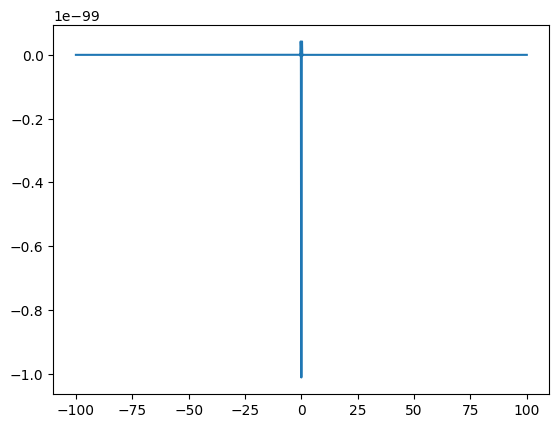

In [110]:
upper, lower = integrate_rk(y, y_bottom, domain(n_space_pts, d=100), get_derivative_matrix(2*n_space_pts+1), Qu=1, Qv=1, T=30, n_steps=1000, return_history=False)
plt.plot(x, lower[:, 0])
plt.show()

In [111]:
resitev_upp, resitev_down, t = integrate_rk(y, y_bottom, domain(n_space_pts, d=100), get_derivative_matrix(2*n_space_pts+1), Qu=1, Qv=1, T=1000, n_steps=15000)

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def animate(x, y, t, y_bottom):
    # Create the figure and axis
    fig, ax = plt.subplots(2, figsize=(9, 6))
    line, = ax[0].plot([], [], lw=2)
    line_bottom = ax[1].plot([], [], lw=2)
    # Define the animation function
    def animate(i):
        line_bottom[0].set_data(x, y_bottom[i])
        line.set_data(x, y[i])
        ax[0].set_xlim(x[0], x[-1])
        ax[0].set_ylim(-1, 1)
        #ax[0].set_xlabel('x')
        #ax[0].set_ylabel('y')
        ax[0].set_title(f't={round(t[i], 3)}')
        ax[0].set_xlim(x[0], x[-1])
        ax[0].set_ylim(-1, 1)
        ax[1].set_xlim(x[0], x[-1])
        ax[1].set_ylim(-1, 1)
        return line, line_bottom
    # Create the animation
    anim = FuncAnimation(fig, animate, frames=len(y), interval=200)
    # Show the animation
    return anim, fig

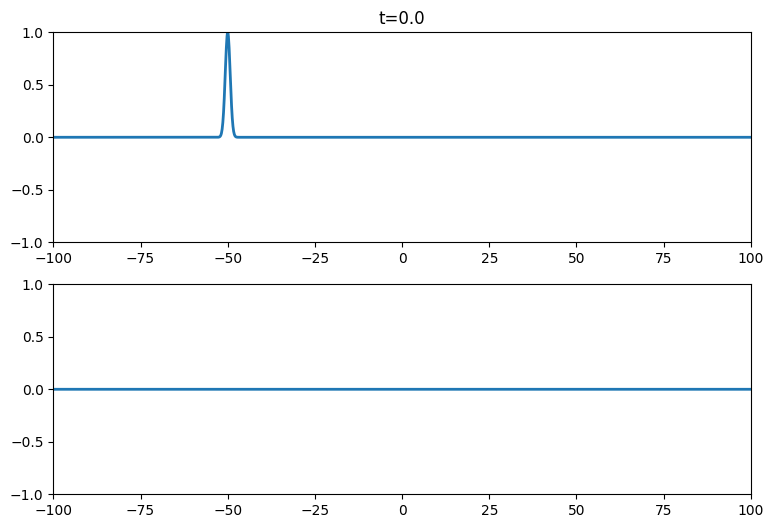

In [112]:
real_duration = 3 # secs   # this doesn't really work for some reason
fps = len(t) / real_duration
# select only 10% of frames
selected = resitev_upp[::30, :, 0]
selected_down = resitev_down[::30, :, 0]
# print(selected.shape)
anim, fig = animate(x, selected, t, -1*selected_down)

In [113]:
anim.save("test.gif", fps=fps)
print("Done - animation saved")

MovieWriter ffmpeg unavailable; using Pillow instead.


Done - animation saved


In [114]:
resitev_down[0]

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]])

In [115]:
selected_down[0]


array([0., 0., 0., ..., 0., 0., 0.])

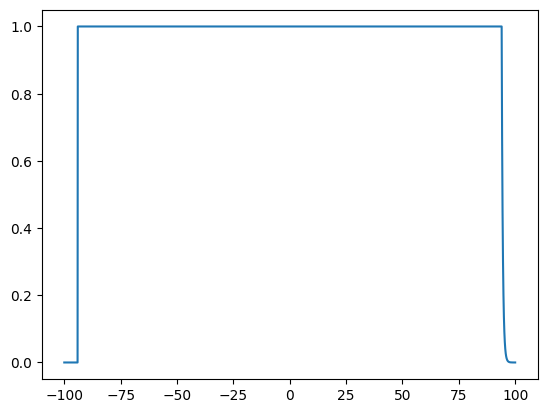

In [116]:
plt.plot(x, [damping_factor(i) for i in x])
plt.show()